In [1]:
import sys
import os

if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

In [2]:
import numpy as np

#import functools
#import itertools
#import toolz

from emtf_algos import *
from emtf_logger import get_logger
from emtf_colormap import get_colormap

In [3]:
# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

import numba
from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.2
[INFO    ] Using tensorflow : 2.4.0
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using numba      : 0.51.2
[INFO    ] Using dask       : 2020.12.0


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

# masked array filling value
ma_fill_value = 999999

#maxevents = 200000
maxevents = -1

# Input files
signal_fname = 'signal_add.20210112.npz'
signal_displ_fname = 'signal_displ_add.20210112.npz'
bkgnd_fname = 'bkgnd_add.20200716.npz'

# Input data columns
part_metadata = ['part_invpt', 'part_eta', 'part_phi',
                 'part_vx', 'part_vy', 'part_vz',
                 'part_d0', 'part_sector', 'part_zone']
part_metadata = dict(zip(part_metadata, range(len(part_metadata))))
#print(part_metadata)

hits_metadata = ['emtf_site', 'emtf_host', 'emtf_chamber',
                 'emtf_segment', 'zones', 'timezones',
                 'emtf_phi', 'emtf_bend', 'emtf_theta',
                 'emtf_theta_alt', 'emtf_qual', 'emtf_qual_alt',
                 'emtf_time', 'strip', 'wire',
                 'fr', 'detlayer', 'bx']
hits_metadata = dict(zip(hits_metadata, range(len(hits_metadata))))
#print(hits_metadata)

# Info regarding phi unit
# 80 deg is converted to (80.*60)/16 = 300 units.
# 30 deg is converted to (30.*60)/16 = 112.5 units.
# 300 units aligned to 16-bit is np.floor(300./16)*16 = 288 units.
# 112.5 units aligned to 16-bit is np.floor(112.5/16) * 16 = 112 units,
# 112 is then lowered to the closest odd number 111.

# Image format
num_channels = 1
num_cols = 288  # 80 degrees
num_rows = 8
image_format = (num_rows, num_cols, num_channels)

# Image sliding window
image_stride = (min_emtf_strip, max_emtf_strip, coarse_emtf_strip)
assert ((max_emtf_strip - min_emtf_strip) // coarse_emtf_strip) == num_cols

# Box image format
num_box_rows = num_rows
num_box_cols = 111  # 30 degrees
num_box_channels = num_channels
box_image_format = (num_box_rows, num_box_cols, num_box_channels)
box_col_offset = (num_box_cols-1) // 2  # (111-1)/2 = 55
assert (num_box_cols % 2) == 1

# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. image_format     : {0}'.format(image_format))
logger.info('.. image_stride     : {0}'.format(image_stride))
logger.info('.. box_image_format : {0}'.format(box_image_format))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. image_format     : (8, 288, 1)
[INFO    ] .. image_stride     : (432, 5040, 16)
[INFO    ] .. box_image_format : (8, 111, 1)


In [5]:
# More settings

ind_part_invpt = part_metadata['part_invpt']
ind_part_d0 = part_metadata['part_d0']
ind_part_eta = part_metadata['part_eta']
ind_part_zone = part_metadata['part_zone']

ind_emtf_host = hits_metadata['emtf_host']
ind_zones = hits_metadata['zones']
ind_timezones = hits_metadata['timezones']
ind_emtf_phi = hits_metadata['emtf_phi']

anchor_row = find_emtf_img_row(3, zone=zone)    # ME2/1
if anchor_row == -99:
  anchor_row = find_emtf_img_row(4, zone=zone)  # ME2/2

# Zone-dependent settings
if zone == 0:
  invpt_bins = np.array([-0.49486, -0.30914, -0.18457, -0.06144, 0.06144, 0.18457, 0.30914, 0.49486])
  dzero_bins = np.array([-149.05425911, -81.99509811, -27.70436335, -3.31677109, 3.31677109, 27.70436335, 81.99509811, 149.05425911])
  activation = 0.06
elif zone == 1:
  invpt_bins = np.array([-0.4943, -0.32499, -0.20098, -0.06069, 0.06069, 0.20098, 0.32499, 0.4943])
  dzero_bins = np.array([-148.39244453, -75.48090935, -24.77919722, -2.7400052, 2.7400052, 24.77919722, 75.48090935, 148.39244453])
  activation = 0.06
elif zone == 2:
  invpt_bins = np.array([-0.46452, -0.25713, -0.15333, -0.06148, 0.06148, 0.15333, 0.25713, 0.46452])
  dzero_bins = np.array([-148.3895298, -73.95162964, -24.58334907, -3.2076813, 3.2076813, 24.58334907, 73.95162964, 148.3895298])
  activation = 0.05
else:
  raise RuntimeError('Could not recognize zone: {0}'.format(zone))

num_invpt_bins = len(invpt_bins)-1
num_d0_bins = len(dzero_bins)-1

In [6]:
# Binning functions

def digitize_invpt_and_d0(invpt, d0):
  # returns (d0_bin, invpt_bin)
  ind0 = hist_digitize_inclusive(invpt, invpt_bins)
  ind1 = hist_digitize_inclusive(d0, dzero_bins)
  return (ind0, ind1)

In [7]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, colorbar=False, ax=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), **kwargs)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges, **kwargs)
  return h, edges, patches

### Load data

In [8]:
def load_signal(fname):
  logger.info('Loading from {0}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(fname):
  logger.info('Loading from {0}'.format(fname))
  with np.load(fname) as loaded:
    out_bkg_aux = loaded['out_aux']
    out_bkg_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_bkg_aux: {0} out_bkg_hits: {1}'.format(out_bkg_aux.shape, out_bkg_hits.shape))
  return (out_bkg_aux, out_bkg_hits)

In [9]:
out_part, out_hits, out_simhits = load_signal(signal_fname)

#out_bkg_aux, out_bkg_hits = load_bkgnd(bkgnd_fname)

[INFO    ] Loading from signal_add.20210112.npz
[INFO    ] out_part: (2000000, 9) out_hits: (2000000, None, 18) out_simhits: (2000000, None, 18)


### Zone selection

In [10]:
# Make zone_mask

part_zone = out_part[:, ind_part_zone].astype(np.int32)
zone_mask = (part_zone == zone)

eta_1p0_2p4_mask = (1.0 <= np.abs(out_part[:, ind_part_eta])) & (np.abs(out_part[:, ind_part_eta]) <= 2.4)  # use etastar?
zone_mask &= eta_1p0_2p4_mask

atleast_1hit_mask = ~(out_simhits.row_lengths == 0)
zone_mask &= atleast_1hit_mask

In [11]:
zone_part = out_part[zone_mask]
zone_hits = ragged_row_boolean_mask(out_hits, zone_mask)
zone_simhits = ragged_row_boolean_mask(out_simhits, zone_mask)

logger.info('zone_part: {0} zone_hits: {1} zone_simhits: {2}'.format(zone_part.shape, zone_hits.shape, zone_simhits.shape))

[INFO    ] zone_part: (653224, 9) zone_hits: (653224, None, 18) zone_simhits: (653224, None, 18)


In [12]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for ievt in range(5):
    print('Event {0}'.format(ievt))
    print(zone_part[ievt])
    print(zone_hits[ievt])
    print(zone_simhits[ievt])

Event 0
[-2.5611117e-01  2.1183386e+00 -6.1635029e-01  6.7432784e-04  9.9125458e-04 -4.6484246e+00
 -1.1986600e-03  5.0000000e+00  0.0000000e+00]
[[   0    0    2    0    4    4 2548    5   18   17    6    6    0    7   14    0    0    0]
 [   2    3   19    0    4    4 2684    2   16   16    6    6    0   25   27    1    0    0]
 [   3    5   28    0    4    4 2819   15   17   16    5    5    0  117   36    0    0    0]
 [   3    5   28    1    4    4 2728    0   16   17    5    5    0  128   33    0    0    0]
 [   4    7   37    0    4    4 2736    0   16   16    5    5    0  127   34    0    0    0]
 [   9    9   55    0    4    4 2505    0   18   18    2    2    0  185  -99    1    0    0]
 [  10   12   73    0    4    4 2675    0   19   19    2    2    0   55  -99    1    0    0]
 [   7   14   82    0    4    4 2888    0   17   17    1    1    1   30  -99    0    0    0]
 [   7   14   82    1    4    4 2714    0   17   17    5    5    1   16  -99    0    0    0]
 [   8   16   91 

### Build images

In [13]:
# Build images

def build_zone_images():
  # zone_images_gt are made from sim hits, while zone_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  zone_images_gt = np.zeros((zone_part.shape[0],) + image_format, dtype=np.bool)
  zone_images = np.zeros((zone_part.shape[0],) + image_format, dtype=np.bool)

  # Get hit variables.
  zone_simhits_row_splits = zone_simhits.row_splits
  zone_simhits_emtf_host = zone_simhits.values[:, ind_emtf_host]
  zone_simhits_zones = zone_simhits.values[:, ind_zones]
  zone_simhits_timezones = zone_simhits.values[:, ind_timezones]
  zone_simhits_emtf_phi = zone_simhits.values[:, ind_emtf_phi]

  zone_hits_row_splits = zone_hits.row_splits
  zone_hits_emtf_host = zone_hits.values[:, ind_emtf_host]
  zone_hits_zones = zone_hits.values[:, ind_zones]
  zone_hits_timezones = zone_hits.values[:, ind_timezones]
  zone_hits_emtf_phi = zone_hits.values[:, ind_emtf_phi]

  # Perform (vectorized) calculations
  zone_simhits_valids = (zone_simhits_zones & (1<<(2-zone))).astype(np.bool) & \
                        (zone_simhits_timezones & (1<<(2-timezone))).astype(np.bool)
  zone_simhits_rows = find_emtf_img_row(zone_simhits_emtf_host, zone=zone)
  zone_simhits_cols = find_emtf_img_col(zone_simhits_emtf_phi)

  zone_hits_valids = (zone_hits_zones & (1<<(2-zone))).astype(np.bool) & \
                     (zone_hits_timezones & (1<<(2-timezone))).astype(np.bool)
  zone_hits_rows = find_emtf_img_row(zone_hits_emtf_host, zone=zone)
  zone_hits_cols = find_emtf_img_col(zone_hits_emtf_phi)

  # Build zone_images_gt
  build_zone_images_jit_0(zone_part,
                          zone_simhits_row_splits,
                          zone_simhits_valids,
                          zone_simhits_rows,
                          zone_simhits_cols,
                          zone_images_gt)
  # Build zone_images
  build_zone_images_jit_0(zone_part,
                          zone_hits_row_splits,
                          zone_hits_valids,
                          zone_hits_rows,
                          zone_hits_cols,
                          zone_images)
  return (zone_images_gt, zone_images)

@njit
def build_zone_images_jit_0(zone_part,
                            zone_simhits_row_splits,
                            zone_simhits_valids,
                            zone_simhits_rows,
                            zone_simhits_cols,
                            zone_images_gt):
  # Loop over events. Get hit variables per event.
  for i in range(zone_part.shape[0]):
    _slice = slice(zone_simhits_row_splits[i], zone_simhits_row_splits[i+1])
    build_zone_images_jit_1(zone_simhits_valids[_slice],
                            zone_simhits_rows[_slice],
                            zone_simhits_cols[_slice],
                            zone_images_gt[i])

@njit
def build_zone_images_jit_1(x_valids,
                            x_rows,
                            x_cols,
                            img):
  # Loop over hits. If hit is valid, set (row, col) to True.
  for i in range(x_valids.shape[0]):
    valid = x_valids[i]
    row = x_rows[i]
    col = x_cols[i]
    if valid and (row >= 0) and (col >= 0):
      img[row, col, :] = 1


In [14]:
# Display images

def display_image(img, cmap=cm.blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(img_row_labels[zone])))
  ax.set_yticklabels(img_row_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

In [15]:
%%time

zone_images_gt, zone_images = build_zone_images()

logger.info('zone_images_gt: {0} zone_images: {1}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (653224, 8, 288, 1) zone_images: (653224, 8, 288, 1)


CPU times: user 1.24 s, sys: 1.2 s, total: 2.45 s
Wall time: 2.51 s


In [16]:
# Make new zone_mask

atleast_2rows_mask = (zone_images_gt.any(axis=-1).any(axis=-1).sum(axis=-1) >= 2)  # reduce on axis=(-2,-1), then count on axis=-3 (row)
zone_mask = atleast_2rows_mask

zone_part = zone_part[zone_mask]
zone_hits = ragged_row_boolean_mask(zone_hits, zone_mask)
zone_simhits = ragged_row_boolean_mask(zone_simhits, zone_mask)
zone_images_gt = zone_images_gt[zone_mask]
zone_images = zone_images[zone_mask]

logger.info('zone_images_gt: {0} zone_images: {1}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (652591, 8, 288, 1) zone_images: (652591, 8, 288, 1)


Event 0
pt: 3.904554343228413


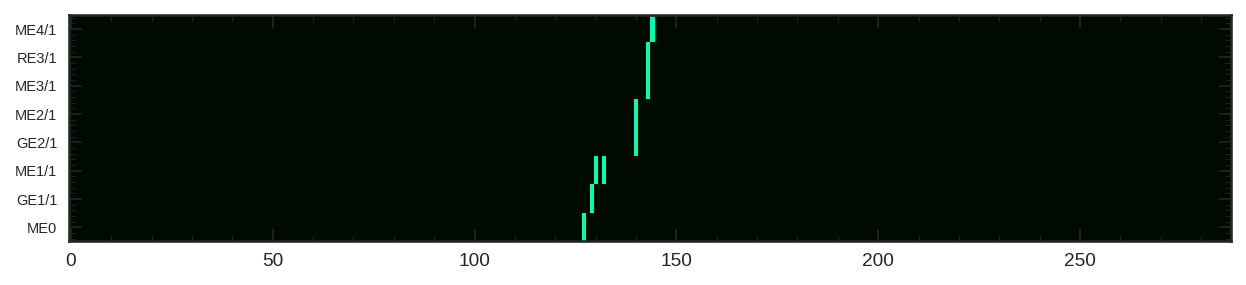

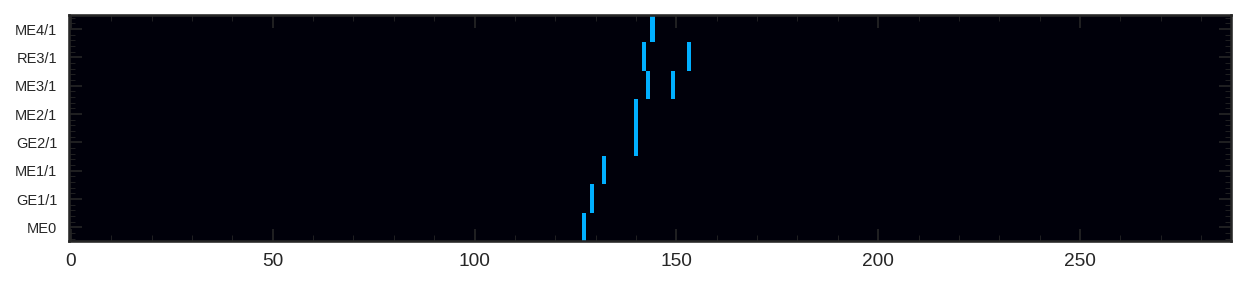

Event 1
pt: 2.4971102464370647


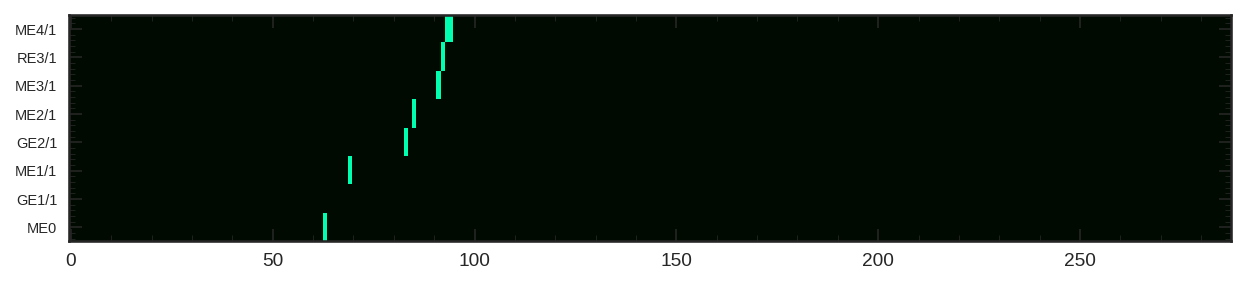

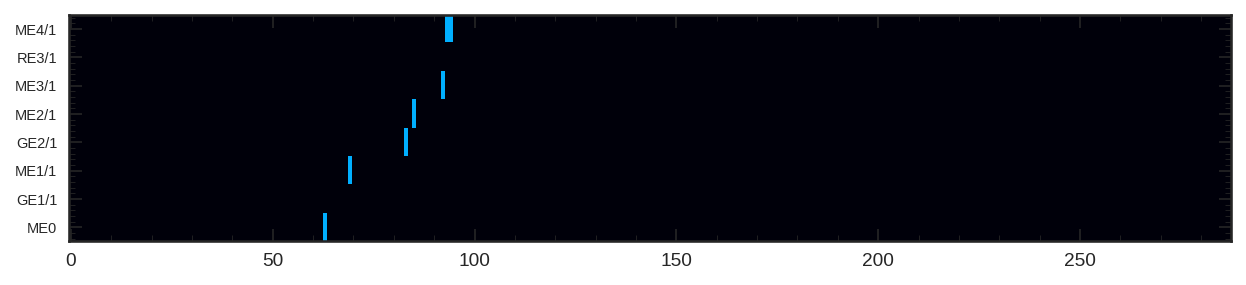

Event 2
pt: 5.663785072639632


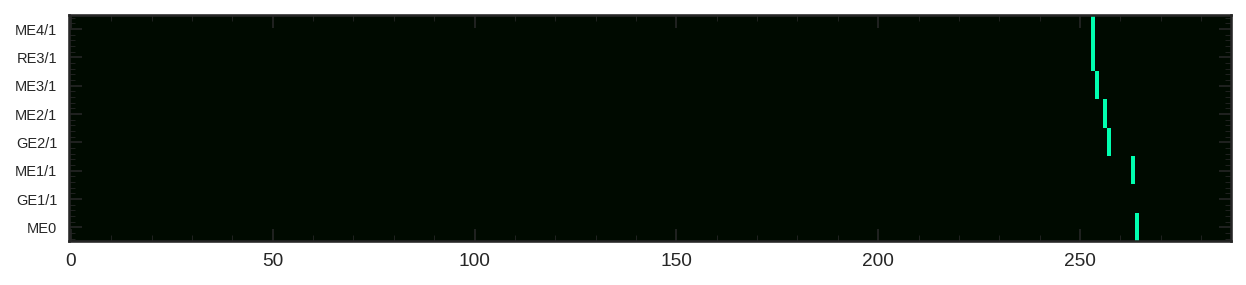

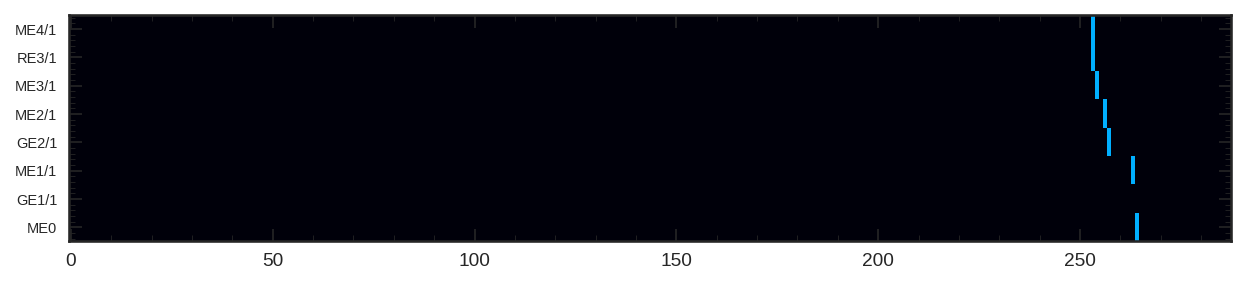

Event 3
pt: 2.8833165498640896


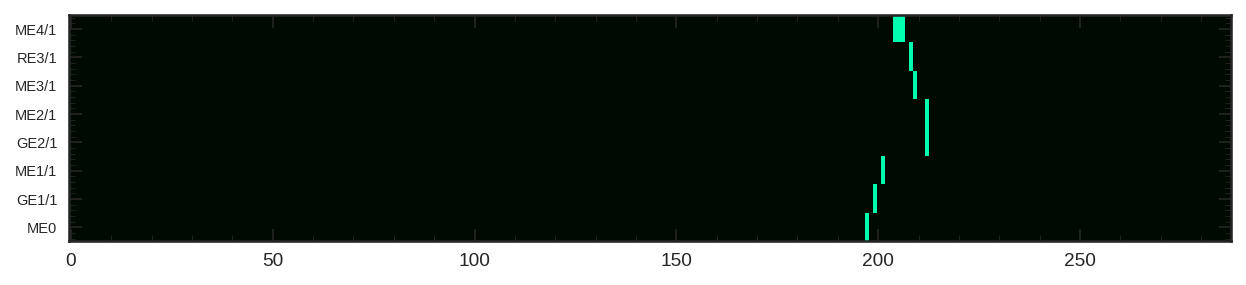

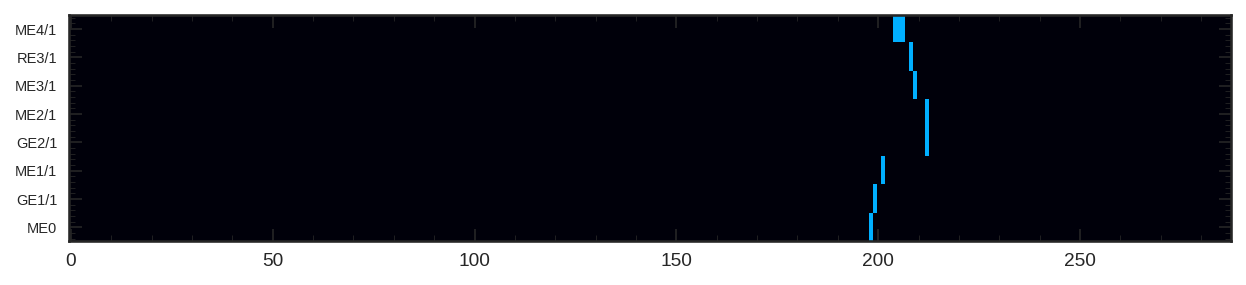

Event 4
pt: 5.602419658472853


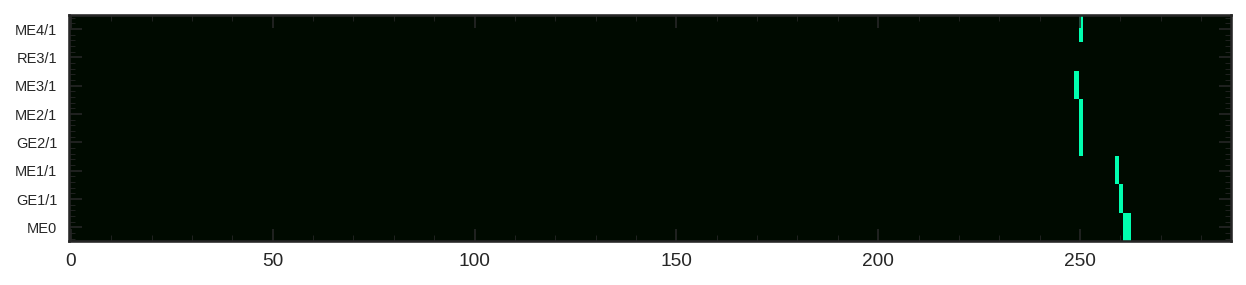

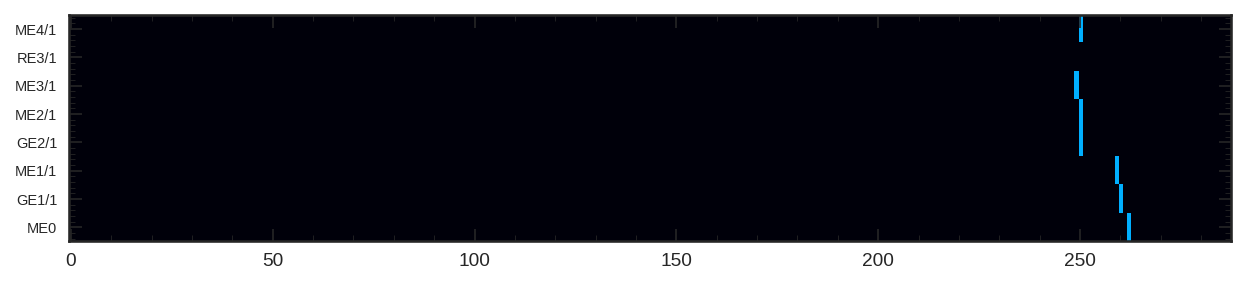

In [17]:
# Debug
for ievt in range(5):
  print('Event {0}'.format(ievt))
  print('pt: {0}'.format(1.0/np.abs(zone_part[ievt, 0])))
  display_image(zone_images_gt[ievt], cmap=cm.green_hot)
  display_image(zone_images[ievt])

### Crop images

In [18]:
# Build boxes

box_invpt_bins, box_d0_bins = digitize_invpt_and_d0(zone_part[:, ind_part_invpt],
                                                    zone_part[:, ind_part_d0])

@njit
def get_box_ranges(anchor_col):
  start = max(0, anchor_col - box_col_offset)
  stop = min(num_cols, anchor_col + box_col_offset + 1)
  b_start = max(0, num_box_cols - stop)
  b_stop = min(num_box_cols, num_cols - start)
  #assert len(range(start, stop)) == len(range(b_start, b_stop))
  return (start, stop, b_start, b_stop)

def build_boxes():
  # 5 indices: (d0_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_d0_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  build_boxes_jit_0(zone_images_gt,
                    box_invpt_bins,
                    box_d0_bins,
                    boxes)
  return boxes

@njit
def build_boxes_jit_0(zone_images_gt,
                      box_invpt_bins,
                      box_d0_bins,
                      boxes):
  # Loop over images. Check if any hit exists in anchor_row.
  for i in range(zone_images_gt.shape[0]):
    img = zone_images_gt[i]
    box_d0_bin, box_invpt_bin = box_d0_bins[i], box_invpt_bins[i]
    if np.any(img[anchor_row, :, 0]):  # only images with true anchors
      # Canon image
      box = boxes[box_d0_bin, box_invpt_bin]
      anchor_col = np.argmax(img[anchor_row, :, 0])
      build_boxes_jit_1(img, box, anchor_col)
      # Mirror image
      img = img[:, ::-1, :]
      box = boxes[(num_d0_bins-1) - box_d0_bin, (num_invpt_bins-1) - box_invpt_bin]
      anchor_col = np.argmax(img[anchor_row, :, 0])
      build_boxes_jit_1(img, box, anchor_col)

@njit
def build_boxes_jit_1(img, box, anchor_col):
  # Normalize image.
  norm = img.sum(axis=-1).sum(axis=-1)
  norm[norm == 0] = 1
  #img = img.astype(np.float32) / norm[:, np.newaxis, np.newaxis]  # unsupported by numba

  # Accumulate.
  start, stop, b_start, b_stop = get_box_ranges(anchor_col)
  tmp_img = img[:, start:stop, :]
  #box[:, b_start:b_stop, :] += tmp_img  # slow for numba
  for i in range(tmp_img.shape[0]):
    for j in range(tmp_img.shape[1]):
      for k in range(tmp_img.shape[2]):
        if (tmp_img[i, j, k] > 0):
          box[i, b_start+j, k] += (1.0/norm[i]) * tmp_img[i, j, k]

def postprocess_boxes(boxes, antialias=True, suppress=True):
  tmp_boxes = boxes.copy()
  if antialias:
    # Applied to anchor_row (ME2) and anchor_row-1 (RE2 or GE2)
    kernel = np.array([1., 2., 1.], dtype=boxes.dtype)
    kernel /= kernel.sum()
    for i in range(tmp_boxes.shape[0]):
      for j in range(tmp_boxes.shape[1]):
        for k in [anchor_row, anchor_row-1]:
          img = boxes[i, j, k, :, 0]
          for l in range(1, img.shape[0]-1):
            tmp_boxes[i, j, k, l, 0] = (img[l-1:l+2] * kernel).sum()

  # Normalize image
  norm = np.sqrt(np.square(tmp_boxes).sum(axis=-1).sum(axis=-1))
  norm[norm == 0] = 1
  boxes_norm = tmp_boxes / norm[:, :, :, np.newaxis, np.newaxis]

  if suppress:
    # Find longest run with valid elements
    def find_longest_run(valid):
      changed = np.append(False, valid[:-1] != valid[1:])
      starts = np.arange(len(valid), dtype=np.int32)
      stops = starts.copy()
      c = 0
      for i in range(len(valid)):
        if valid[i]:
          if changed[i]:
            c = i
          stops[c] += 1
      lengths = (stops - starts)
      c = np.argmax(lengths)
      return (starts[c], stops[c])

    # Suppress small values
    for i in range(tmp_boxes.shape[0]):
      for j in range(tmp_boxes.shape[1]):
        for k in range(tmp_boxes.shape[2]):
          img = boxes[i, j, k, :, 0]
          start, stop = find_longest_run(img > 1./num_box_cols)
          # Set values outside the longest run to zero
          img[:start] = 0
          img[stop:] = 0
  return (boxes_norm, boxes)


In [19]:
# Display boxes

def display_boxes(boxes, cmap=None, figsize=(7.5,7.5)):
  fig, axs = plt.subplots(num_d0_bins, num_invpt_bins, figsize=figsize,
                          sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_d0_bins):
    for j in range(num_invpt_bins):
      ax = axs[(num_d0_bins-1)-i, j]  # axs[0,0] is top left
      img = boxes[i, j]
      ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
      for x in [-40, -20, 0, +20, +40]:  # custom grid lines
        ax.plot([box_col_offset+x,box_col_offset+x], [-0.5,num_box_rows-0.5], color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

def display_box(img, cmap=None, figsize=(3,3)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.grid(False)
  for x in [-40, -20, 0, +20, +40]:  # custom grid lines
    ax.plot([box_col_offset+x,box_col_offset+x], [-0.5,num_box_rows-0.5], color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

In [20]:
%%time

boxes = build_boxes()
boxes_norm, boxes = postprocess_boxes(boxes)

logger.info('boxes_norm: {0} boxes: {1}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 30.3 s, sys: 502 ms, total: 30.8 s
Wall time: 30.8 s


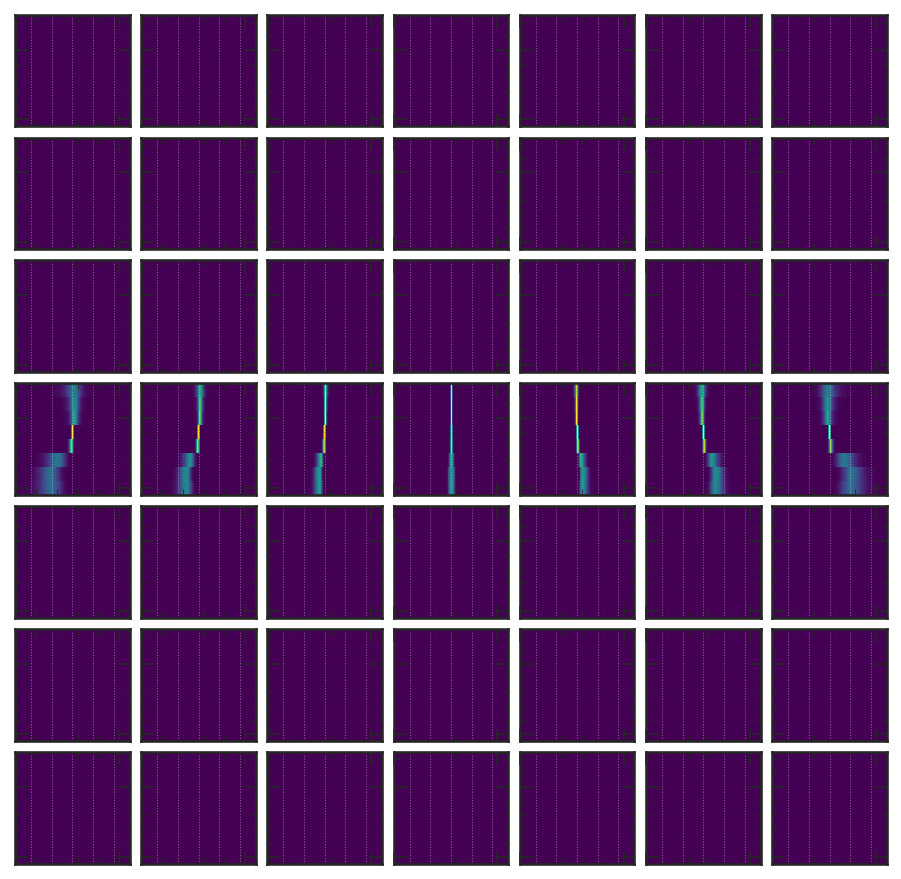

In [21]:
display_boxes(boxes_norm)

In [22]:
# Crop images

def build_zone_box_images():
  # zone_box_images_gt are made from sim hits, while zone_box_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  zone_box_images_gt = np.zeros((zone_part.shape[0],) + box_image_format, dtype=np.bool)
  zone_box_images = np.zeros((zone_part.shape[0],) + box_image_format, dtype=np.bool)
  zone_box_anchors = np.zeros(zone_part.shape[0], dtype=np.int32)

  # Find anchors.
  build_zone_box_images_jit_0(zone_images_gt,
                              box_invpt_bins,
                              box_d0_bins,
                              boxes_norm,
                              zone_box_anchors)

  # Build zone_box_images_gt.
  build_zone_box_images_jit_2(zone_images_gt,
                              zone_box_anchors,
                              zone_box_images_gt)
  # Build zone_box_images.
  build_zone_box_images_jit_2(zone_images,
                              zone_box_anchors,
                              zone_box_images)
  return (zone_box_images_gt, zone_box_images, zone_box_anchors)

@njit
def build_zone_box_images_jit_0(zone_images_gt,
                                box_invpt_bins,
                                box_d0_bins,
                                boxes_norm,
                                zone_box_anchors):
  # Loop over images. Find the anchor_col.
  for i in range(zone_images_gt.shape[0]):
    img = zone_images_gt[i]
    box = boxes_norm[box_d0_bins[i], box_invpt_bins[i]]
    zone_box_anchors[i] = build_zone_box_images_jit_1(img, box)

@njit
def build_zone_box_images_jit_1(img, box):
  accumulated = np.zeros(num_cols, dtype=np.float32)

  # Guess the possible anchor_col values
  img_cols = []
  for i in range(num_cols):
    if img[:, i, :].any():
      img_cols.append(i)
  img_cols_start = max(0, img_cols[0]-10)
  img_cols_stop = min(num_cols, img_cols[-1]+11)

  # Loop over the possible anchor_col values.
  for anchor_col in range(img_cols_start, img_cols_stop):
    # Accumulate.
    start, stop, b_start, b_stop = get_box_ranges(anchor_col)
    tmp_img = img[:, start:stop, :]
    #accumulated[anchor_col] += np.sum(box[:, b_start:b_stop, :] * tmp_img)  # slow for numba
    for i in range(tmp_img.shape[0]):
      for j in range(tmp_img.shape[1]):
        for k in range(tmp_img.shape[2]):
          if (box[i, b_start+j, k] > 0) or (tmp_img[i, j, k] > 0):
            accumulated[anchor_col] += box[i, b_start+j, k] * tmp_img[i, j, k]

  # Get the best anchor_col
  anchor_col = np.argmax(accumulated)
  return anchor_col

@njit
def build_zone_box_images_jit_2(zone_images_gt,
                                zone_box_anchors,
                                zone_box_images_gt):
  # Loop over images. Crop around anchor_col.
  for i in range(zone_images_gt.shape[0]):
    anchor_col = zone_box_anchors[i]
    start, stop, b_start, b_stop = get_box_ranges(anchor_col)
    zone_box_images_gt[i][:, b_start:b_stop, :] = zone_images_gt[i][:, start:stop, :]


In [23]:
%%time

zone_box_images_gt, zone_box_images, zone_box_anchors = build_zone_box_images()

logger.info('zone_box_images_gt: {0} zone_box_images: {1} zone_box_anchors: {2}'.format(zone_box_images_gt.shape, zone_box_images.shape, zone_box_anchors.shape))

[INFO    ] zone_box_images_gt: (652591, 8, 111, 1) zone_box_images: (652591, 8, 111, 1) zone_box_anchors: (652591,)


CPU times: user 1min 2s, sys: 1.93 s, total: 1min 4s
Wall time: 1min 3s


Event 0
pt: 3.904554343228413


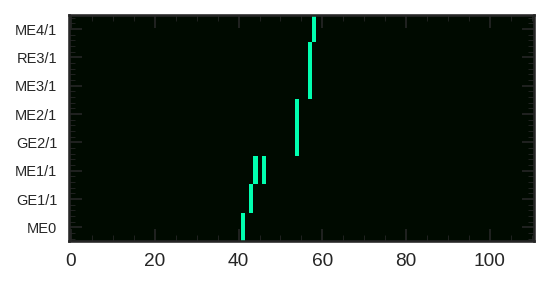

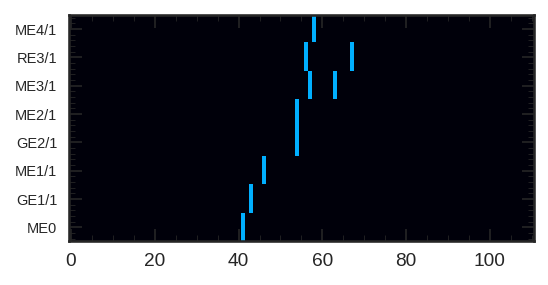

Event 1
pt: 2.4971102464370647


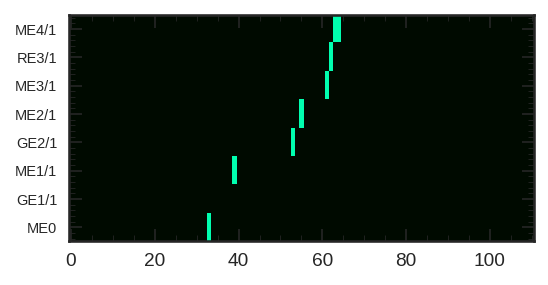

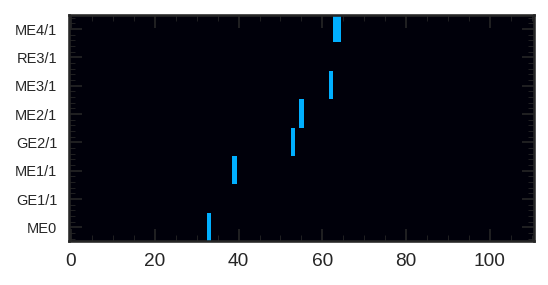

Event 2
pt: 5.663785072639632


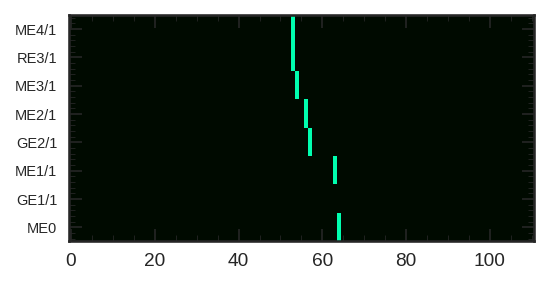

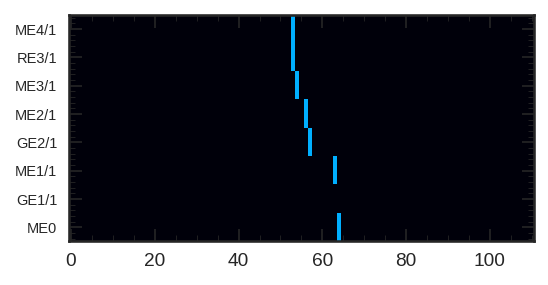

Event 3
pt: 2.8833165498640896


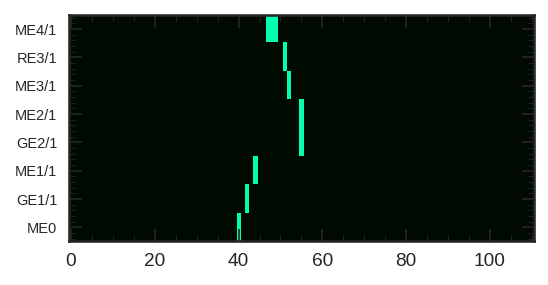

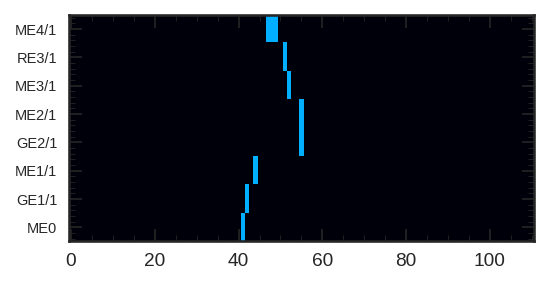

Event 4
pt: 5.602419658472853


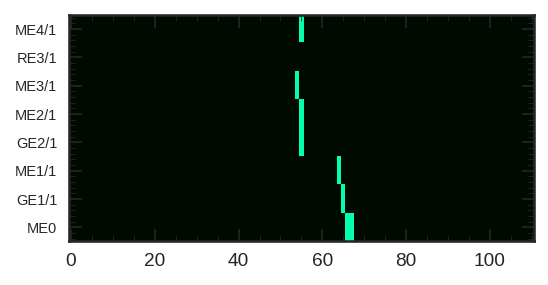

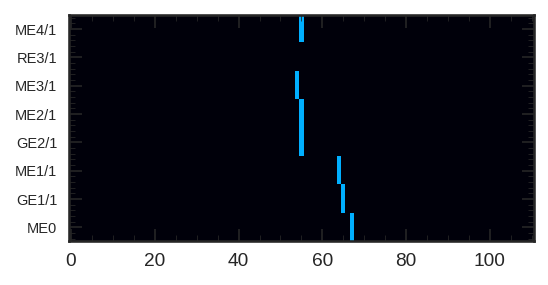

In [24]:
# Debug
for ievt in range(5):
  print('Event {0}'.format(ievt))
  print('pt: {0}'.format(1.0/np.abs(zone_part[ievt, 0])))
  display_image(zone_box_images_gt[ievt], figsize=(4,2), cmap=cm.green_hot)
  display_image(zone_box_images[ievt], figsize=(4,2))

In [25]:
# Rebuild boxes from cropped images

def rebuild_boxes():
  # 5 indices: (d0_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_d0_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  # Build from zone_box_images (instead of zone_box_images_gt)
  rebuild_boxes_jit_0(zone_box_images,
                      box_invpt_bins,
                      box_d0_bins,
                      boxes)
  return boxes

@njit
def rebuild_boxes_jit_0(zone_box_images,
                        box_invpt_bins,
                        box_d0_bins,
                        boxes):
  # Loop over images. Check if any hit exists in anchor_row.
  for i in range(zone_box_images.shape[0]):
    img = zone_box_images[i]
    box_d0_bin, box_invpt_bin = box_d0_bins[i], box_invpt_bins[i]
    if True:  # all images (with or without anchors)
      # Canon image
      box = boxes[box_d0_bin, box_invpt_bin]
      anchor_col = box_col_offset
      build_boxes_jit_1(img, box, anchor_col)
      # Mirror image
      img = img[:, ::-1, :]
      box = boxes[(num_d0_bins-1) - box_d0_bin, (num_invpt_bins-1) - box_invpt_bin]
      anchor_col = box_col_offset
      build_boxes_jit_1(img, box, anchor_col)

In [26]:
%%time

boxes = rebuild_boxes()
boxes_norm, boxes = postprocess_boxes(boxes, antialias=False, suppress=False)

logger.info('boxes_norm: {0} boxes: {1}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 14.7 s, sys: 319 ms, total: 15 s
Wall time: 15 s


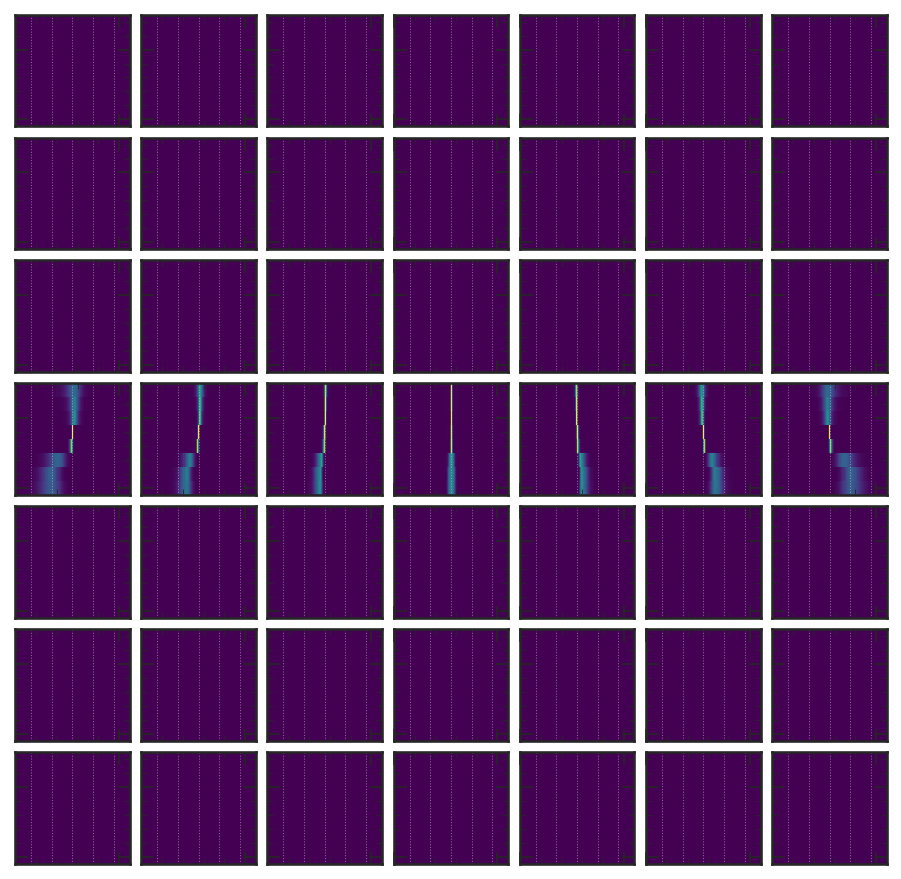

In [27]:
display_boxes(boxes_norm)

### Create patterns

In [28]:
# Apply activation threshold

boxes_act = (boxes_norm > activation)

# Check for weird spikes
def antispike():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and not img[l-1] and not img[l+1]:
            print('Found spike at {0}'.format((i, j, k, l, 0)))

# Check for range
def antirange():
  padding = 36
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and (l < (box_col_offset - padding) or l > (box_col_offset + padding)):
            print('Found too wide range at {0}'.format((i, j, k, l, 0)))

antispike()
antirange()

In [29]:
# Ad-hoc fixes

if zone == 0:
  boxes_act[3, 0, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 1, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 5, 3, 54, 0] = 1  # GE2/1
  boxes_act[3, 6, 3, 54, 0] = 1  # GE2/1
elif zone == 1:
  boxes_act[3, 0, 4, 54, 0] = 1  # ME2/1
  boxes_act[3, 6, 4, 56, 0] = 1  # ME2/1
  #
  boxes_act[3, 0, 0, 42, 0] = 0  # GE1/1
  boxes_act[3, 0, 1, 45, 0] = 0  # ME1/1
  boxes_act[3, 6, 0, 68, 0] = 0  # GE1/1
  boxes_act[3, 6, 1, 65, 0] = 0  # ME1/1
  #
  boxes_act[3, 0, 0, 18, 0] = 0  # GE1/1
  boxes_act[3, 0, 1, 18, 0] = 0  # ME1/1
  boxes_act[3, 6, 0, 92, 0] = 0  # GE1/1
  boxes_act[3, 6, 1, 92, 0] = 0  # ME1/1
  #
  boxes_act[3, 0, 3, 58, 0] = 0  # GE2/1
  boxes_act[3, 1, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 2, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 4, 3, 54, 0] = 1  # GE2/1
  boxes_act[3, 5, 3, 54, 0] = 1  # GE2/1
  boxes_act[3, 6, 3, 52, 0] = 0  # GE2/1
elif zone == 2:
  boxes_act[3, 2, 4, 54, 0] = 1  # ME3/2
  boxes_act[3, 3, 4, 54, 0] = 1  # ME3/2
  boxes_act[3, 3, 4, 56, 0] = 1  # ME3/2
  boxes_act[3, 4, 4, 56, 0] = 1  # ME3/2
  #
  boxes_act[3, 0, 2, 58, 0] = 0  # RE2/2
  boxes_act[3, 0, 2, 59, 0] = 0  # RE2/2
  boxes_act[3, 6, 2, 52, 0] = 0  # RE2/2
  boxes_act[3, 6, 2, 51, 0] = 0  # RE2/2
  #
  boxes_act[3, 2, 0, 55, 0] = 1  # ME1/2
  boxes_act[3, 4, 0, 55, 0] = 1  # ME1/2

antispike()
antirange()

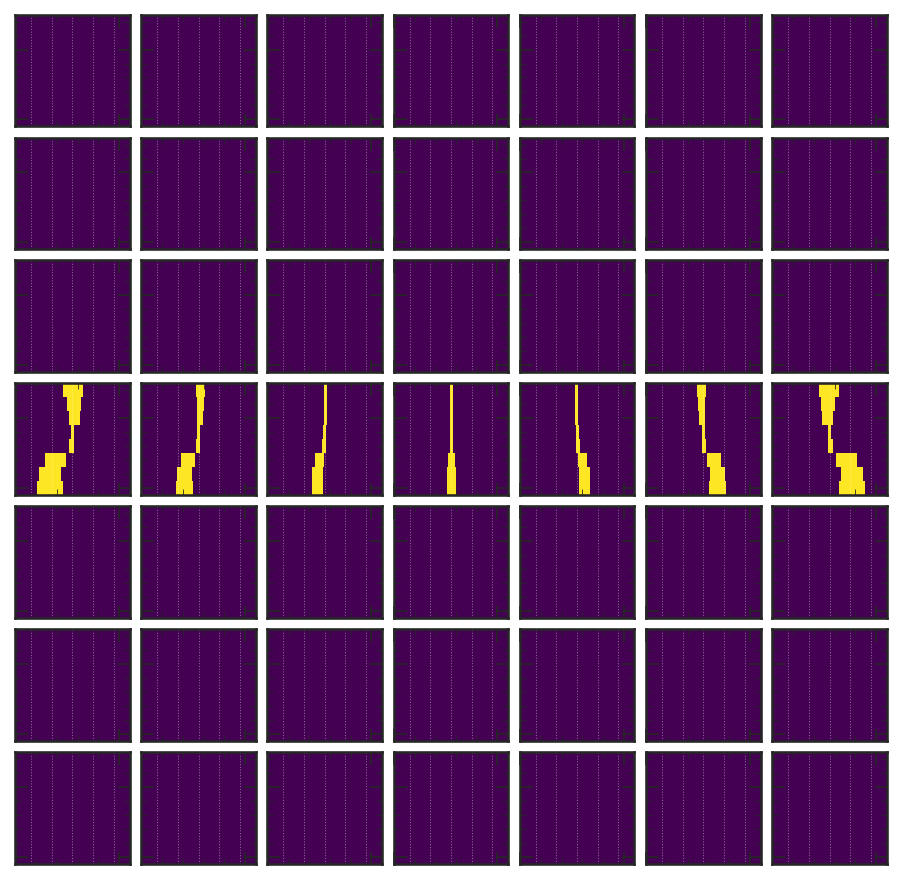

In [30]:
display_boxes(0.8 * boxes_act)

In [31]:
check_efficiency_activation = False

if check_efficiency_activation:
  def find_efficiency_activation(boxes_act_tmp):
    # Count number of stations before and after applying patterns
    accumulated = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)
    accumulated_act = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)

    for i in range(num_d0_bins):
      for j in range(num_invpt_bins):
        mask = (box_d0_bins == i) & (box_invpt_bins == j)
        tmp_images = zone_box_images[mask]
        box = boxes_act_tmp[i, j]
        accumulated[i, j] += (tmp_images.any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)
        accumulated_act[i, j] += ((box & tmp_images).any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)

    accumulated[accumulated == 0] = 1
    result = np.true_divide(accumulated_act, accumulated)
    return result.astype(np.float32)

  with np.printoptions(precision=5):
    for act in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]:
      boxes_act_tmp = (boxes_norm > act)
      print(act, find_efficiency_activation(boxes_act_tmp))

In [32]:
check_pattern_overlaps = False

if check_pattern_overlaps:
  display_box(0.5 * boxes_act[3,3], figsize=(2,2))
  display_box(0.5 * boxes_act[3,3] + 0.5 * boxes_act[3,4], figsize=(2,2))
  display_box(0.5 * boxes_act[3,4] + 0.5 * boxes_act[3,5], figsize=(2,2))
  display_box(0.5 * boxes_act[3,5] + 0.5 * boxes_act[3,6], figsize=(2,2))

In [33]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row, box_col_offset-10:box_col_offset+11].reshape(-1))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row-1, box_col_offset-10:box_col_offset+11].reshape(-1))

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
# Make pattern windows

#boxes_middle = boxes[..., 0].argmax(axis=-1)  # find the column with max activation
boxes_middle = (boxes[..., 0] * (0.5 + np.arange(num_box_cols))).sum(axis=-1)  # find the weighted mean
boxes_middle_norm = (boxes[..., 0]).sum(axis=-1)
boxes_middle_norm[boxes_middle_norm == 0] = 1
boxes_middle /= boxes_middle_norm
#print(boxes_middle)

# Ad-hoc fixes
boxes_middle[3, 3, :] = box_col_offset

boxes_middle = np.asarray(boxes_middle, dtype=np.int32)
boxes_start = np.zeros(boxes_middle.shape, dtype=np.int32)
boxes_stop = np.zeros(boxes_middle.shape, dtype=np.int32)

for i in range(boxes_act.shape[0]):
  for j in range(boxes_act.shape[1]):
    for k in range(boxes_act.shape[2]):
      for l in range(boxes_act.shape[3]):
        if boxes_act[i, j, k, l, 0] == 1:
          boxes_start[i, j, k] = l
          break
      for l in reversed(range(boxes_act.shape[3])):
        if boxes_act[i, j, k, l, 0] == 1:
          boxes_stop[i, j, k] = l
          break

patterns = np.stack((boxes_start, boxes_middle, boxes_stop))
patterns = np.moveaxis(patterns, 0, -1)

patterns_winsize = boxes_stop - boxes_start + 1
patterns_winsize[patterns_winsize == 1] = 0

logger.info('patterns: {0}'.format(patterns.shape))

[INFO    ] patterns: (7, 7, 8, 3)


In [36]:
# Debug
print(patterns[3, :])
print(patterns_winsize[3, :])

boxes_act2 = np.zeros(boxes_act.shape, dtype=boxes_act.dtype)
for i in range(patterns.shape[0]):
  for j in range(patterns.shape[1]):
    for k in range(patterns.shape[2]):
      l0, l1, l2 = patterns[i, j, k]
      if l2 > l0:
        boxes_act2[i, j, k, l0:l2+1, 0] = 1
assert np.all(boxes_act2 == boxes_act)

[[[21 33 45]
  [23 33 43]
  [29 39 48]
  [52 54 56]
  [54 55 56]
  [52 57 62]
  [50 56 63]
  [46 55 65]]

 [[34 42 49]
  [35 42 48]
  [39 45 51]
  [53 54 56]
  [54 55 56]
  [54 57 59]
  [54 57 60]
  [53 57 61]]

 [[43 49 53]
  [43 49 53]
  [46 50 54]
  [53 55 56]
  [54 55 56]
  [55 56 57]
  [55 56 57]
  [55 56 57]]

 [[51 55 59]
  [51 55 59]
  [52 55 58]
  [54 55 56]
  [54 55 56]
  [54 55 56]
  [54 55 56]
  [54 55 56]]

 [[57 61 67]
  [57 61 67]
  [56 60 64]
  [54 55 57]
  [54 55 56]
  [53 54 55]
  [53 54 55]
  [53 54 55]]

 [[61 68 76]
  [62 68 75]
  [59 65 71]
  [54 56 57]
  [54 55 56]
  [51 53 56]
  [50 53 56]
  [49 53 57]]

 [[65 77 89]
  [67 77 87]
  [62 71 81]
  [54 56 58]
  [54 55 56]
  [48 53 58]
  [47 54 60]
  [45 55 64]]]
[[25 21 20  5  3 11 14 20]
 [16 14 13  4  3  6  7  9]
 [11 11  9  4  3  3  3  3]
 [ 9  9  7  3  3  3  3  3]
 [11 11  9  4  3  3  3  3]
 [16 14 13  4  3  6  7  9]
 [25 21 20  5  3 11 14 20]]


In [37]:
# Make pattern quality

patterns_quality = np.true_divide(patterns_winsize, patterns_winsize[3,3])
patterns_quality = np.sqrt(np.square(patterns_quality).sum(axis=-1))
#patterns_quality = patterns_quality.sum(axis=-1)
patterns_quality_norm = patterns_quality.copy()
patterns_quality_norm[patterns_quality_norm == 0] = 1
patterns_quality[patterns_quality != 0] = patterns_quality[3,3]
patterns_quality /= patterns_quality_norm
patterns_quality = np.expand_dims(patterns_quality, axis=-1)
print(patterns_quality[3, :])

# Find hit bitmap
po2_coeffs = (2 ** np.arange(num_box_rows))  # [1,2,4,8,16,32,64,128]

accumulated_0 = np.zeros((num_d0_bins, num_invpt_bins, (2 ** num_box_rows)), dtype=np.int64)

for i in range(num_d0_bins):
  for j in range(num_invpt_bins):
    mask = (box_d0_bins == i) & (box_invpt_bins == j)
    tmp_images = zone_box_images[mask]
    if tmp_images.size > 0:
      tmp_images_hitmap = (tmp_images.any(axis=-1).any(axis=-1) * po2_coeffs).sum(axis=-1)  # reduce on axis=(-2,-1), then calc dot-product on axis=-3 (row)
      accumulated_0[i, j] = np.bincount(tmp_images_hitmap)  # like np.histogram() for unit bin size
#print(accumulated_0[3, :])

accumulated_1 = np.zeros((num_d0_bins, num_invpt_bins, (2 ** num_box_rows)), dtype=np.int64)  # cumulative of accumulated_0

# Postprocessing
for i in range(num_d0_bins):
  for j in range(num_invpt_bins):
    for lhs in range(accumulated_1.shape[2]):
      for rhs in range(accumulated_1.shape[2]):
        if (lhs & rhs) == rhs:
          accumulated_1[i, j, lhs] += accumulated_0[i, j, rhs]
#print(accumulated_1[3, :])

hitmap_quality = (accumulated_1[3, :] * patterns_quality[3, :]).sum(axis=0)
hitmap_quality_indices = np.argsort(hitmap_quality)
hitmap_quality_ranks = np.zeros(hitmap_quality.shape, dtype=np.int32)
hitmap_quality_ranks[hitmap_quality_indices] = np.arange(hitmap_quality.shape[0])

with np.printoptions(threshold=10):
  print(hitmap_quality.shape, hitmap_quality.min(), hitmap_quality.max())
  print(hitmap_quality)
  print(hitmap_quality_indices)
  print(hitmap_quality_ranks)

[[0.2763314 ]
 [0.51424716]
 [0.87627926]
 [1.        ]
 [0.87627926]
 [0.51424716]
 [0.2763314 ]]
(256,) 19.080220179330006 372290.0849799221
[1.90802202e+01 2.13813837e+02 1.59900412e+02 ... 2.10972410e+05
 1.31587583e+04 3.72290085e+05]
[  0  32  64 ... 247 253 255]
[  0  73  57 ... 254 246 255]


In [38]:
# Debug
with np.printoptions(precision=5):
  for i in range(0, 256, 8):
    print(' '.join(['{0:08b}'.format(x) for x in hitmap_quality_indices[i:i+8]]))

00000000 00100000 01000000 10000000 00010000 11000000 01100000 10100000
00110000 01010000 10010000 01110000 10110000 11010000 11100000 00001000
01001000 10001000 00101000 11001000 00011000 01101000 10101000 01011000
10011000 00111000 01111000 11101000 10111000 11011000 11110000 00000100
00100100 10000100 01000100 10100100 01100100 11000100 00010100 00110100
01010100 10010100 11100100 00001100 10001100 01001100 00101100 01110100
10101100 01101100 11001100 00011100 10110100 11010100 10011100 01011100
00111100 00000010 00100010 01000010 00010010 01100010 10000010 01010010
00110010 10010010 11000010 10100010 01110010 11111000 11010010 11100010
10110010 00000001 00100001 01000001 10000001 00010001 01100001 11000001
00110001 10100001 01010001 00001010 11101100 01110001 10010001 01001010
01111100 10001010 00101010 00011010 11001010 11100001 01011010 01101010
10110001 10011010 10101010 00111010 11011010 11010001 11101010 01111010
10111100 11110010 00000011 00000110 00100011 01000011 00010011 0

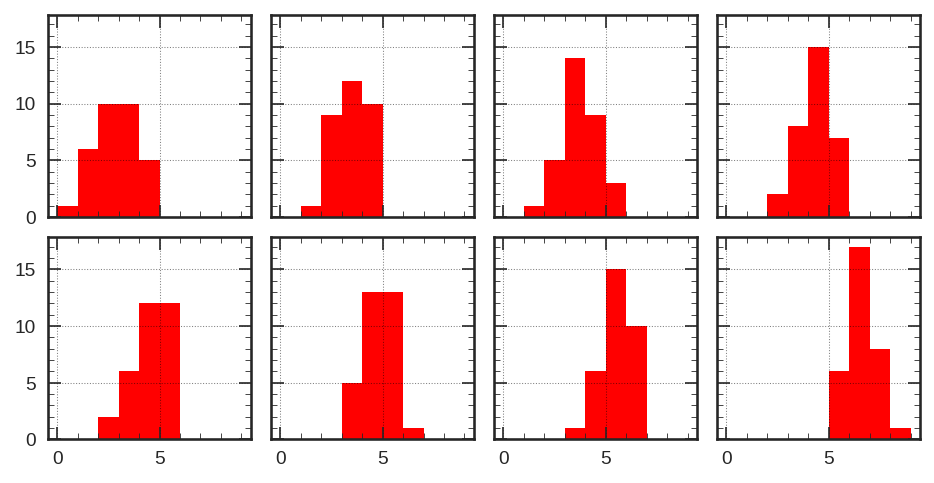

In [39]:
fig, axs = plt.subplots(2, 4, figsize=(7.5, 7.5/2),
                        sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
for i in range(8):
  ax = axs[i//4, i%4]
  hist = np.zeros(num_rows + 1, dtype=np.int32)
  start, stop = i * (hitmap_quality.shape[0]//8), (i+1) * (hitmap_quality.shape[0]//8)
  for j in hitmap_quality_indices[start:stop]:
    kk = 0
    for k in range(num_rows):  # count num of set bits
      if j & (1 << k):
        kk += 1
    hist[kk] += 1

  hist_on_binned_array(hist, edges=np.arange(hist.shape[0] + 1), color='red', ax=ax)

plt.show()

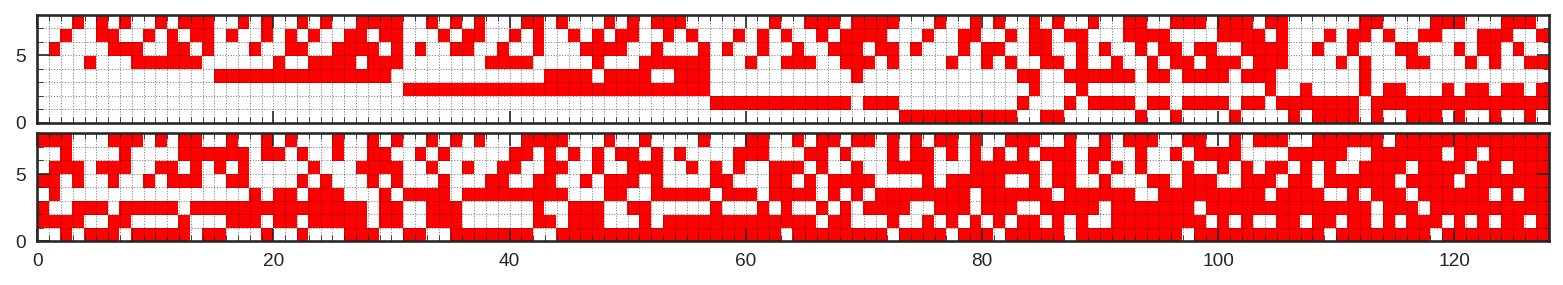

In [40]:
from matplotlib.ticker import AutoMinorLocator

fig, axs = plt.subplots(2, 1, figsize=(13, 2),
                        sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
for i in range(2):
  ax = axs[i]
  hist = np.zeros((hitmap_quality.shape[0]//2, num_rows), dtype=np.int32)
  start, stop = i * (hitmap_quality.shape[0]//2), (i+1) * (hitmap_quality.shape[0]//2)
  for j in hitmap_quality_indices[start:stop]:
    jj = hitmap_quality_ranks[j] - start
    for k in range(num_rows):  # check set bits
      if j & (1 << k):
        hist[jj, k] = 1

  hist2d_on_binned_array(hist, xedges=np.arange(hist.shape[0] + 1), yedges=np.arange(hist.shape[1] + 1),
                         cmap=cm.red_binary, ax=ax)
  ax.grid(True, which='both')
  ax.xaxis.set_minor_locator(AutoMinorLocator(20))
  ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.show()

In [41]:
# Write to file
outfile = 'patterns_zone%i.npz' % zone
outdict = {
  'patterns': patterns,
  'boxes_act': boxes_act,
  'boxes_norm': boxes_norm,
  'boxes': boxes,
  'hitmap_quality': hitmap_quality,
  'hitmap_quality_ranks': hitmap_quality_ranks,
}
save_np_arrays(outfile, outdict)
logger.info('Wrote to {0}'.format(outfile))

[INFO    ] Wrote to patterns_zone0.npz


In [42]:
zone_sparse_images_gt = dense_to_sparse(zone_images_gt)
zone_sparse_images = dense_to_sparse(zone_images)
logger.info('zone_sparse_images_gt: {0} zone_sparse_images: {1}'.format(zone_sparse_images_gt.dense_shape, zone_sparse_images.dense_shape))

[INFO    ] zone_sparse_images_gt: (652591, 8, 288, 1) zone_sparse_images: (652591, 8, 288, 1)


In [43]:
# Write to hdf5 file
outfile = 'zone_images_zone%i.h5' % zone
outdict = {
  'zone_part': da.from_array(zone_part),
  'zone_hits_values': da.from_array(zone_hits.values),
  'zone_hits_row_splits': da.from_array(zone_hits.row_splits),
  'zone_simhits_values': da.from_array(zone_simhits.values),
  'zone_simhits_row_splits': da.from_array(zone_simhits.row_splits),
  'zone_box_anchors': da.from_array(zone_box_anchors),
  'zone_sparse_images_gt_indices': da.from_array(zone_sparse_images_gt.indices),
  'zone_sparse_images_gt_values': da.from_array(zone_sparse_images_gt.values),
  'zone_sparse_images_gt_dense_shape': da.from_array(zone_sparse_images_gt.dense_shape),
  'zone_sparse_images_indices': da.from_array(zone_sparse_images.indices),
  'zone_sparse_images_values': da.from_array(zone_sparse_images.values),
  'zone_sparse_images_dense_shape': da.from_array(zone_sparse_images.dense_shape),
}
da.to_hdf5(outfile, outdict, compression='lzf')
logger.info('Wrote to {0}'.format(outfile))

[INFO    ] Wrote to zone_images_zone0.h5


### Tune invpt and d0 binning (disabled)

In [44]:
check_binning_invpt_and_d0 = False

if check_binning_invpt_and_d0:
  zone_part_invpt_tmp = zone_part[:, ind_part_invpt]
  zone_part_invpt_tmp = np.hstack((zone_part_invpt_tmp, -zone_part_invpt_tmp))
  zone_part_dzero_tmp = zone_part[:, ind_part_d0]
  zone_part_dzero_tmp = np.hstack((zone_part_dzero_tmp, -zone_part_dzero_tmp))
  with np.printoptions(precision=5):
    #print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5,100./7,200./7,300./7,400./7,500./7,600./7,99.5], overwrite_input=True))
    #print('dzero_bins:\n', np.percentile(zone_part_dzero_tmp, [0.5,300./12,500./12,588./12,612./12,700./12,900./12,99.5], overwrite_input=True))
    if zone == 0:
      print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5, 18.75, 31.25, 43.75, 56.25, 68.75, 81.25, 99.5], overwrite_input=True))
    elif zone == 1:
      print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5, 17.5, 30.0, 44.0, 56.0, 70.0, 82.5, 99.5], overwrite_input=True))
    elif zone == 2:
      print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5, 18.75, 31.25, 42.5, 57.5, 68.75, 81.25, 99.5], overwrite_input=True))

In [45]:
really_check_binning_invpt_and_d0 = False

if really_check_binning_invpt_and_d0:
  invpt_bins_tmp = np.array([-1000., -1000., -1000., -1000., 1000., 1000., 1000., 1000.])
  dzero_bins_tmp = np.array([-1000., -1000., -1000., -1000., 1000., 1000., 1000., 1000.])
  invpt_bins_pct_tmp = np.array([-1000., -1000, -1000., -1000., 1000., 1000., 1000., 1000.])
  dzero_bins_pct_tmp = np.array([-1000., -1000, -1000., -1000., 1000., 1000., 1000., 1000.])

  def digitize_invpt_and_d0_tmp(invpt, d0):
    # returns (d0_bin, invpt_bin)
    ind0 = hist_digitize_inclusive(invpt, invpt_bins_tmp)  # use invpt_bins_tmp
    ind1 = hist_digitize_inclusive(d0, dzero_bins_tmp)     # use dzero_bins_tmp
    return (ind0, ind1)

  def rebuild_boxes_tmp():
    # 5 indices: (d0_bin, invpt_bin, img_row, img_col, img_channel)
    boxes = np.zeros((num_d0_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

    # Call digitize_invpt_and_d0_tmp()
    box_invpt_bins, box_d0_bins = digitize_invpt_and_d0_tmp(zone_part[:, ind_part_invpt],
                                                            zone_part[:, ind_part_d0])

    # Build from zone_box_images (instead of zone_box_images_gt)
    rebuild_boxes_jit_0(zone_box_images,
                        box_invpt_bins,
                        box_d0_bins,
                        boxes)
    return boxes

  def find_efficiency_activation_tmp(boxes_act_tmp):
    # Count number of stations before and after applying patterns
    accumulated = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)
    accumulated_act = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)

    # Call digitize_invpt_and_d0_tmp()
    box_invpt_bins, box_d0_bins = digitize_invpt_and_d0_tmp(zone_part[:, ind_part_invpt],
                                                            zone_part[:, ind_part_d0])

    for i in range(num_d0_bins):
      for j in range(num_invpt_bins):
        mask = (box_d0_bins == i) & (box_invpt_bins == j)
        tmp_images = zone_box_images[mask]
        box = boxes_act_tmp[i, j]
        accumulated[i, j] += (tmp_images.any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)
        accumulated_act[i, j] += ((box & tmp_images).any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)

    accumulated[accumulated == 0] = 1
    result = np.true_divide(accumulated_act, accumulated)
    return result.astype(np.float32)

  me1_row = find_emtf_img_row(0, zone=zone)    # ME1/1
  if me1_row == -99:
    me1_row = find_emtf_img_row(1, zone=zone)  # ME1/2

  zone_part_invpt_tmp = zone_part[:, ind_part_invpt]
  zone_part_invpt_tmp = np.hstack((zone_part_invpt_tmp, -zone_part_invpt_tmp))
  zone_part_dzero_tmp = zone_part[:, ind_part_d0]
  zone_part_dzero_tmp = np.hstack((zone_part_dzero_tmp, -zone_part_dzero_tmp))

  # 40 edges in invpt
  N = 40
  _linspace = np.linspace(0, 100, num=2*N+1)
  _linspace[0] += 0.5
  _linspace[-1] -= 0.5
  zone_part_invpt_pct = np.percentile(zone_part_invpt_tmp, _linspace, overwrite_input=True)
  #print(_linspace, zone_part_invpt_pct, sep='\n')

  def find_efficiency_and_area():
    boxes_tmp = rebuild_boxes_tmp()
    boxes_norm_tmp, boxes_tmp = postprocess_boxes(boxes_tmp, antialias=False, suppress=False)
    #display_boxes(boxes_norm_tmp)
    boxes_act_tmp = (boxes_norm_tmp > activation)
    eff = find_efficiency_activation_tmp(boxes_act_tmp)
    eff = eff[R, S]
    area = np.flatnonzero(boxes_act_tmp[R, S, me1_row, :, 0])
    return (eff, area)

  # Result array
  result = np.zeros((num_d0_bins, num_invpt_bins) + (N,), dtype=np.float32)

  R, S = 3, 3  # (d0_bin, invpt_bin)
  S1, S2 = S, S+1  # edges for invpt_bin
  for i in range(N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.05:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [46]:
if really_check_binning_invpt_and_d0:
  best_i = 4  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  R, S = 3, 4  # (d0_bin, invpt_bin)
  S1, S2 = S-2, S+1  # edges for invpt_bin
  for i in range(best_i+1, N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.05:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [47]:
if really_check_binning_invpt_and_d0:
  best_i = 14  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  R, S = 3, 5  # (d0_bin, invpt_bin)
  S1, S2 = S-4, S+1  # edges for invpt_bin
  for i in range(best_i+1, N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.04:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [48]:
if really_check_binning_invpt_and_d0:
  best_i = 24  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  R, S = 3, 6  # (d0_bin, invpt_bin)
  S1, S2 = S-6, S+1  # edges for invpt_bin
  for i in range(best_i+1, N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.02:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [49]:
if really_check_binning_invpt_and_d0:
  best_i = N-1  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  print(invpt_bins_tmp)
  print(invpt_bins_pct_tmp)